#to green


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from PIL import ImageEnhance
def only_green(image_path,save_path):

  # Load the image
  img = Image.open(image_path)
  # Create an enhancer object
  #enhancer = ImageEnhance.Contrast(img)
  # Increase the contrast
  #img = enhancer.enhance(1.5)
  # Convert the image to RGB if it's not already in that format
  img = img.convert('RGB')

  # Get the width and height of the image
  width, height = img.size

  # Iterate over each pixel
  for y in range(height):
      for x in range(width):
          # Get the RGB values of the pixel
          r, g, b = img.getpixel((x, y))

          # Check if green intensity is higher than red and blue
          if g >= r*0.73 and  g >= b*1.5:
              img.putpixel((x, y), (r, g, b))  # Set the pixel to black
          else:
              img.putpixel((x, y), (0, 0, 0))  # Set the pixel to black

  # Save the modified image
  img.save(save_path)


In [ ]:
folder_path = '/content/drive/MyDrive/olive/segmented'
save_path="/content/drive/MyDrive/olive/green_only"
import os
# Iterate over each file in the folder
for filename in os.listdir(folder_path):
    # Check if the file is an image
    if filename.endswith('.jpg') or filename.endswith('.png'):
        # Get the full path of the image
        image_path = os.path.join(folder_path, filename)
        output_path = os.path.join(save_path,filename)
        # Process the image
        only_green(image_path,output_path)

#Point_E

In [5]:
!git clone https://github.com/openai/point-e.git

Cloning into 'point-e'...
remote: Enumerating objects: 57, done.
remote: Counting objects: 100% (57/57), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 57 (delta 7), reused 51 (delta 7), pack-reused 0
Receiving objects: 100% (57/57), 1.56 MiB | 2.94 MiB/s, done.
Resolving deltas: 100% (7/7), done.


In [6]:
cd ..

/


In [7]:
cd content/point-e/

/content/point-e


In [8]:
pip install -e .

Obtaining file:///content/point-e
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-install-qotn0pv6/clip_4905a2d93c7f4335bb4271c444b70016
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-install-qotn0pv6/clip_4905a2d93c7f4335bb4271c444b70016
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 5.9 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369498 sha256=53b725e174a27fc39b8ba2fa560869dab8ceb305c47e0b92393f7e6e8f3e7146
  Stored in directory: /tmp/pip-ephem-wheel-cache-y2x_bl4k/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
  Created wheel for fire: filename=fire-0.5.0-py

In [9]:
from PIL import Image
import torch
from tqdm.auto import tqdm
import cv2
from point_e.diffusion.configs import DIFFUSION_CONFIGS, diffusion_from_config
from point_e.diffusion.sampler import PointCloudSampler
from point_e.models.download import load_checkpoint
from point_e.models.configs import MODEL_CONFIGS, model_from_config
from point_e.util.plotting import plot_point_cloud



In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('creating base model...')
base_name = 'base40M' # use base300M or base1B for better results
base_model = model_from_config(MODEL_CONFIGS[base_name], device)
base_model.eval()
base_diffusion = diffusion_from_config(DIFFUSION_CONFIGS[base_name])

print('creating upsample model...')
upsampler_model = model_from_config(MODEL_CONFIGS['upsample'], device)
upsampler_model.eval()
upsampler_diffusion = diffusion_from_config(DIFFUSION_CONFIGS['upsample'])

print('downloading base checkpoint...')
base_model.load_state_dict(load_checkpoint(base_name, device))

print('downloading upsampler checkpoint...')
upsampler_model.load_state_dict(load_checkpoint('upsample', device))


creating base model...


100%|███████████████████████████████████████| 890M/890M [00:14<00:00, 62.3MiB/s]


creating upsample model...
downloading base checkpoint...


  0%|          | 0.00/162M [00:00<?, ?iB/s]

downloading upsampler checkpoint...


  0%|          | 0.00/162M [00:00<?, ?iB/s]

<All keys matched successfully>

In [11]:
sampler = PointCloudSampler(
    device=device,
    models=[base_model, upsampler_model],
    diffusions=[base_diffusion, upsampler_diffusion],
    num_points=[1024],
    aux_channels=['R', 'G', 'B'],
    guidance_scale=[3.0, 3.0],
)

In [ ]:
import pandas as pd
folder_path="/content/drive/MyDrive/olive/green_only"
csv="/content/drive/MyDrive/olive/Tree_height.csv"
save="/content/drive/MyDrive/olive/fig/"
import numpy as np
h5_label=[]
h5_data=[]
import os
import matplotlib.pyplot as plt

# Iterate over each file in the folder

reader = pd.read_csv(csv)
for filename in os.listdir(folder_path):
      # Check if the file is an image
      if filename.endswith('.jpg') or filename.endswith('.png'):
        for j in range(len(reader)):
          if reader["filename"][j] == filename:
            # Extract the height from the current row
            height = reader["height"][j]
        h5_label.append(height)
        img=Image.open(os.path.join(folder_path,filename))
        samples=None
        for x in tqdm(sampler.sample_batch_progressive(batch_size=1, model_kwargs=dict(images=[img]))):
          samples = x
        pc = sampler.output_to_point_clouds(samples)[0]
        fig = plot_point_cloud(pc, grid_size=3, fixed_bounds=((-0.75, -0.75, -0.75),(0.75, 0.75, 0.75)))
        #fig = np.array(fig)
        plt.savefig(save+filename)
        h5_data.append(pc.coords)
        print(len(h5_data))
        print(len(h5_label))
h5_data=np.array(h5_data)
h5_label=np.array(h5_label)

0it [00:00, ?it/s]

1
1


0it [00:00, ?it/s]

2
2


0it [00:00, ?it/s]

3
3


0it [00:00, ?it/s]

4
4


0it [00:00, ?it/s]

5
5


0it [00:00, ?it/s]

6
6


0it [00:00, ?it/s]

7
7


0it [00:00, ?it/s]

8
8


0it [00:00, ?it/s]

9
9


0it [00:00, ?it/s]

10
10


0it [00:00, ?it/s]

11
11


0it [00:00, ?it/s]

12
12


0it [00:00, ?it/s]

13
13


0it [00:00, ?it/s]

14
14


0it [00:00, ?it/s]

15
15


0it [00:00, ?it/s]

16
16


0it [00:00, ?it/s]

17
17


0it [00:00, ?it/s]

18
18


0it [00:00, ?it/s]

19
19


0it [00:00, ?it/s]

20
20


0it [00:00, ?it/s]

/content/point-e/point_e/util/plotting.py:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(8, 8))


21
21


0it [00:00, ?it/s]

22
22


0it [00:00, ?it/s]

23
23


0it [00:00, ?it/s]

24
24


0it [00:00, ?it/s]

25
25


0it [00:00, ?it/s]

26
26


0it [00:00, ?it/s]

27
27


0it [00:00, ?it/s]

28
28


0it [00:00, ?it/s]

29
29


0it [00:00, ?it/s]

30
30


0it [00:00, ?it/s]

31
31


0it [00:00, ?it/s]

32
32


0it [00:00, ?it/s]

33
33


0it [00:00, ?it/s]

34
34


0it [00:00, ?it/s]

35
35


0it [00:00, ?it/s]

36
36


0it [00:00, ?it/s]

37
37


0it [00:00, ?it/s]

38
38


0it [00:00, ?it/s]

39
39


0it [00:00, ?it/s]

40
40


0it [00:00, ?it/s]

41
41


0it [00:00, ?it/s]

42
42


0it [00:00, ?it/s]

43
43


0it [00:00, ?it/s]

44
44


0it [00:00, ?it/s]

45
45


0it [00:00, ?it/s]

46
46


0it [00:00, ?it/s]

47
47


0it [00:00, ?it/s]

48
48


0it [00:00, ?it/s]

49
49


0it [00:00, ?it/s]

50
50


0it [00:00, ?it/s]

51
51


0it [00:00, ?it/s]

52
52


0it [00:00, ?it/s]

53
53


0it [00:00, ?it/s]

54
54


0it [00:00, ?it/s]

55
55


0it [00:00, ?it/s]

56
56


0it [00:00, ?it/s]

57
57


0it [00:00, ?it/s]

58
58


0it [00:00, ?it/s]

59
59


0it [00:00, ?it/s]

60
60


0it [00:00, ?it/s]

61
61


0it [00:00, ?it/s]

62
62


0it [00:00, ?it/s]

63
63


0it [00:00, ?it/s]

64
64


0it [00:00, ?it/s]

65
65


0it [00:00, ?it/s]

66
66


0it [00:00, ?it/s]

67
67


0it [00:00, ?it/s]

68
68


0it [00:00, ?it/s]

69
69


0it [00:00, ?it/s]

70
70


0it [00:00, ?it/s]

71
71


0it [00:00, ?it/s]

72
72


0it [00:00, ?it/s]

73
73


0it [00:00, ?it/s]

74
74


0it [00:00, ?it/s]

75
75


0it [00:00, ?it/s]

76
76


0it [00:00, ?it/s]

77
77


0it [00:00, ?it/s]

78
78


0it [00:00, ?it/s]

79
79


0it [00:00, ?it/s]

80
80


0it [00:00, ?it/s]

81
81


0it [00:00, ?it/s]

82
82


0it [00:00, ?it/s]

83
83


0it [00:00, ?it/s]

84
84


0it [00:00, ?it/s]

85
85


0it [00:00, ?it/s]

86
86


0it [00:00, ?it/s]

87
87


0it [00:00, ?it/s]

88
88


0it [00:00, ?it/s]

89
89


0it [00:00, ?it/s]

90
90


0it [00:00, ?it/s]

91
91


0it [00:00, ?it/s]

92
92


0it [00:00, ?it/s]

93
93


0it [00:00, ?it/s]

94
94


0it [00:00, ?it/s]

95
95


0it [00:00, ?it/s]

96
96


0it [00:00, ?it/s]

97
97


0it [00:00, ?it/s]

98
98


0it [00:00, ?it/s]

99
99


0it [00:00, ?it/s]

100
100


0it [00:00, ?it/s]

101
101


0it [00:00, ?it/s]

102
102


0it [00:00, ?it/s]

103
103


0it [00:00, ?it/s]

104
104


0it [00:00, ?it/s]

105
105


0it [00:00, ?it/s]

106
106


0it [00:00, ?it/s]

107
107


0it [00:00, ?it/s]

108
108


0it [00:00, ?it/s]

109
109


0it [00:00, ?it/s]

110
110


0it [00:00, ?it/s]

111
111


0it [00:00, ?it/s]

112
112


0it [00:00, ?it/s]

113
113


0it [00:00, ?it/s]

114
114


0it [00:00, ?it/s]

115
115


0it [00:00, ?it/s]

116
116


0it [00:00, ?it/s]

117
117


0it [00:00, ?it/s]

118
118


0it [00:00, ?it/s]

119
119


0it [00:00, ?it/s]

120
120


0it [00:00, ?it/s]

121
121


0it [00:00, ?it/s]

122
122


0it [00:00, ?it/s]

123
123


0it [00:00, ?it/s]

124
124


0it [00:00, ?it/s]

125
125


0it [00:00, ?it/s]

126
126


0it [00:00, ?it/s]

127
127


0it [00:00, ?it/s]

128
128


0it [00:00, ?it/s]

129
129


0it [00:00, ?it/s]

130
130


0it [00:00, ?it/s]

131
131


0it [00:00, ?it/s]

132
132


0it [00:00, ?it/s]

133
133


0it [00:00, ?it/s]

134
134


0it [00:00, ?it/s]

135
135


0it [00:00, ?it/s]

136
136


0it [00:00, ?it/s]

137
137


0it [00:00, ?it/s]

138
138


0it [00:00, ?it/s]

139
139


0it [00:00, ?it/s]

140
140


0it [00:00, ?it/s]

141
141


0it [00:00, ?it/s]

142
142


0it [00:00, ?it/s]

143
143


0it [00:00, ?it/s]

144
144


0it [00:00, ?it/s]

145
145


0it [00:00, ?it/s]

146
146


0it [00:00, ?it/s]

147
147


0it [00:00, ?it/s]

148
148


0it [00:00, ?it/s]

149
149


0it [00:00, ?it/s]

150
150


0it [00:00, ?it/s]

151
151


0it [00:00, ?it/s]

152
152


0it [00:00, ?it/s]

153
153


0it [00:00, ?it/s]

154
154


0it [00:00, ?it/s]

155
155


0it [00:00, ?it/s]

156
156


0it [00:00, ?it/s]

157
157


0it [00:00, ?it/s]

158
158


0it [00:00, ?it/s]

159
159


0it [00:00, ?it/s]

160
160


0it [00:00, ?it/s]

161
161


0it [00:00, ?it/s]

162
162


0it [00:00, ?it/s]

163
163


0it [00:00, ?it/s]

164
164


0it [00:00, ?it/s]

165
165


0it [00:00, ?it/s]

166
166


0it [00:00, ?it/s]

167
167


0it [00:00, ?it/s]

168
168


0it [00:00, ?it/s]

169
169


0it [00:00, ?it/s]

170
170


0it [00:00, ?it/s]

171
171


0it [00:00, ?it/s]

172
172


0it [00:00, ?it/s]

173
173


0it [00:00, ?it/s]

174
174


0it [00:00, ?it/s]

175
175


0it [00:00, ?it/s]

176
176


0it [00:00, ?it/s]

177
177


0it [00:00, ?it/s]

178
178


0it [00:00, ?it/s]

179
179


0it [00:00, ?it/s]

180
180


0it [00:00, ?it/s]

181
181


0it [00:00, ?it/s]

182
182


0it [00:00, ?it/s]

183
183


0it [00:00, ?it/s]

184
184


0it [00:00, ?it/s]

185
185


0it [00:00, ?it/s]

186
186


0it [00:00, ?it/s]

187
187


0it [00:00, ?it/s]

188
188


0it [00:00, ?it/s]

189
189


0it [00:00, ?it/s]

190
190


0it [00:00, ?it/s]

191
191


0it [00:00, ?it/s]

192
192


0it [00:00, ?it/s]

193
193


0it [00:00, ?it/s]

194
194


0it [00:00, ?it/s]

195
195


0it [00:00, ?it/s]

196
196


0it [00:00, ?it/s]

197
197


0it [00:00, ?it/s]

198
198


0it [00:00, ?it/s]

199
199


0it [00:00, ?it/s]

200
200


0it [00:00, ?it/s]

201
201


0it [00:00, ?it/s]

202
202


0it [00:00, ?it/s]

203
203


0it [00:00, ?it/s]

204
204


0it [00:00, ?it/s]

205
205


0it [00:00, ?it/s]

206
206


0it [00:00, ?it/s]

207
207


0it [00:00, ?it/s]

208
208


0it [00:00, ?it/s]

209
209


0it [00:00, ?it/s]

210
210


0it [00:00, ?it/s]

211
211


0it [00:00, ?it/s]

212
212


0it [00:00, ?it/s]

213
213


0it [00:00, ?it/s]

214
214


0it [00:00, ?it/s]

215
215


0it [00:00, ?it/s]

216
216


0it [00:00, ?it/s]

217
217


0it [00:00, ?it/s]

218
218


0it [00:00, ?it/s]

219
219


0it [00:00, ?it/s]

220
220


0it [00:00, ?it/s]

221
221


0it [00:00, ?it/s]

222
222


0it [00:00, ?it/s]

223
223


0it [00:00, ?it/s]

224
224


0it [00:00, ?it/s]

225
225


0it [00:00, ?it/s]

226
226


0it [00:00, ?it/s]

227
227


0it [00:00, ?it/s]

228
228


0it [00:00, ?it/s]

229
229


0it [00:00, ?it/s]

230
230


0it [00:00, ?it/s]

231
231


0it [00:00, ?it/s]

232
232


0it [00:00, ?it/s]

233
233


0it [00:00, ?it/s]

234
234


0it [00:00, ?it/s]

235
235


0it [00:00, ?it/s]

236
236


0it [00:00, ?it/s]

237
237


0it [00:00, ?it/s]

238
238


0it [00:00, ?it/s]

239
239


0it [00:00, ?it/s]

240
240


0it [00:00, ?it/s]

241
241


0it [00:00, ?it/s]

242
242


0it [00:00, ?it/s]

243
243


0it [00:00, ?it/s]

244
244


0it [00:00, ?it/s]

245
245


0it [00:00, ?it/s]

246
246


0it [00:00, ?it/s]

247
247


0it [00:00, ?it/s]

248
248


0it [00:00, ?it/s]

249
249


0it [00:00, ?it/s]

250
250


0it [00:00, ?it/s]

251
251


0it [00:00, ?it/s]

252
252


0it [00:00, ?it/s]

253
253


0it [00:00, ?it/s]

254
254


0it [00:00, ?it/s]

255
255


0it [00:00, ?it/s]

256
256


0it [00:00, ?it/s]

257
257


0it [00:00, ?it/s]

258
258


0it [00:00, ?it/s]

259
259


0it [00:00, ?it/s]

260
260


0it [00:00, ?it/s]

261
261


0it [00:00, ?it/s]

262
262


0it [00:00, ?it/s]

263
263


0it [00:00, ?it/s]

264
264


0it [00:00, ?it/s]

265
265


0it [00:00, ?it/s]

266
266


0it [00:00, ?it/s]

267
267


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

KeyboardInterrupt: ignored

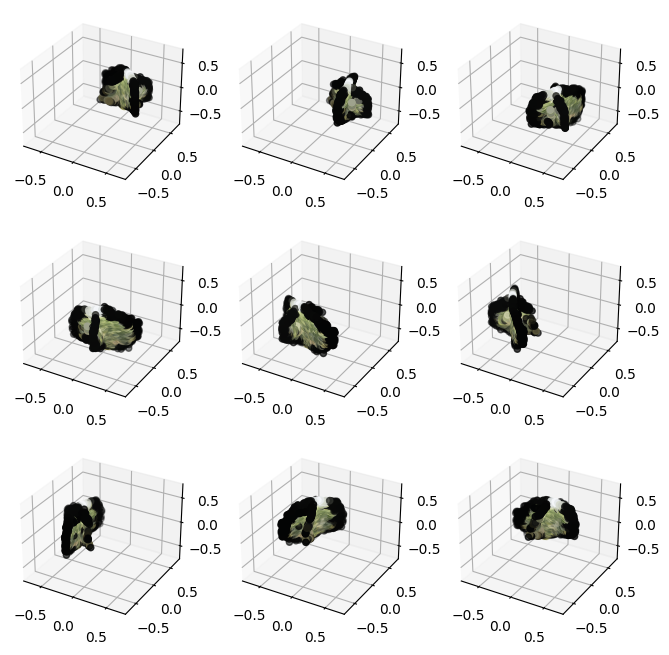

In [ ]:
import pandas as pd
folder_path="/content/drive/MyDrive/olive/green_only"
csv="/content/drive/MyDrive/olive/Tree_height.csv"


import os
# Iterate over each file in the folder

reader = pd.read_csv(csv)
for filename in os.listdir(folder_path):
      # Check if the file is an image
      if filename.endswith('.jpg') or filename.endswith('.png'):
        img=Image.open(os.path.join(folder_path,filename))
        samples=None
        for x in tqdm(sampler.sample_batch_progressive(batch_size=1, model_kwargs=dict(images=[img]))):
          samples = x
        pc = sampler.output_to_point_clouds(samples)[0]
        fig = plot_point_cloud(pc, grid_size=3, fixed_bounds=((-0.75, -0.75, -0.75),(0.75, 0.75, 0.75)))


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

KeyboardInterrupt: ignored

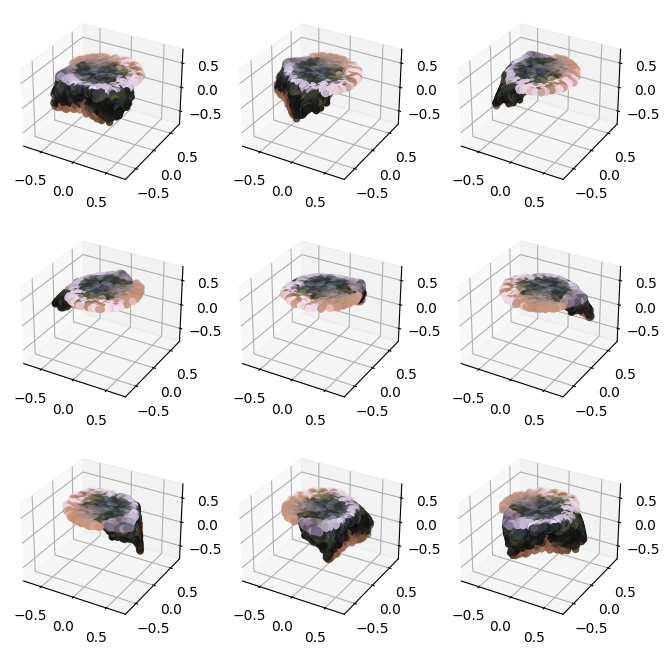

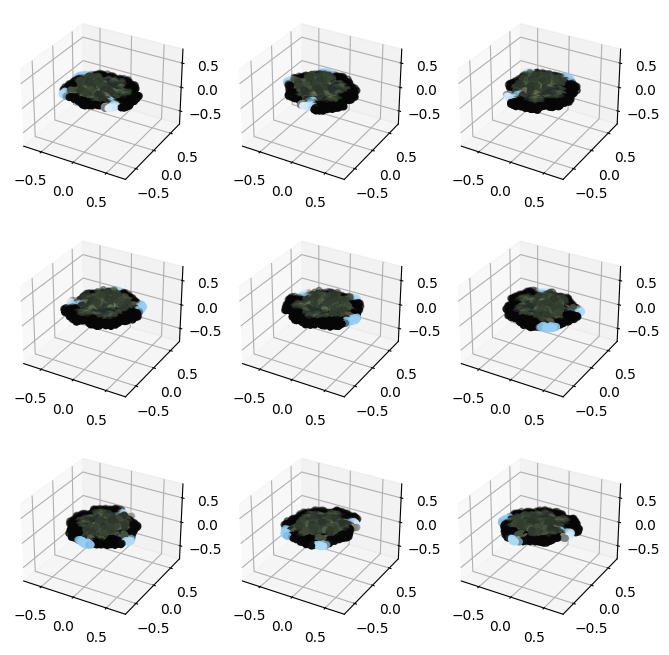

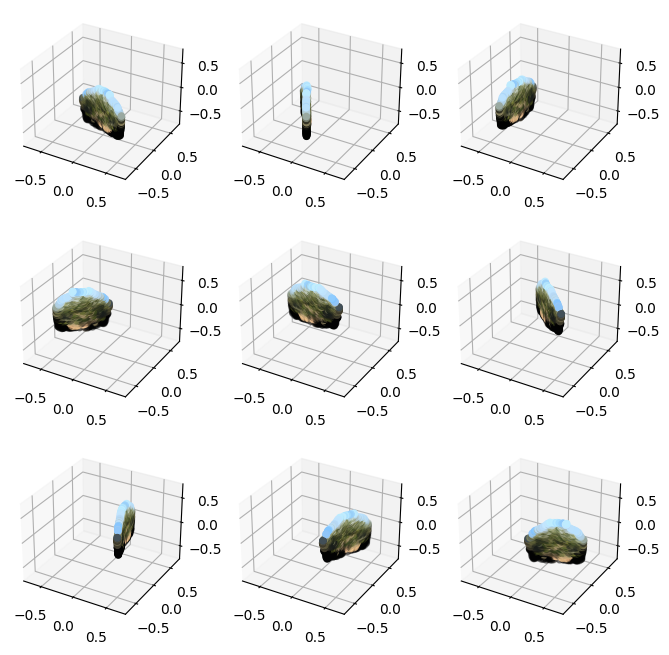

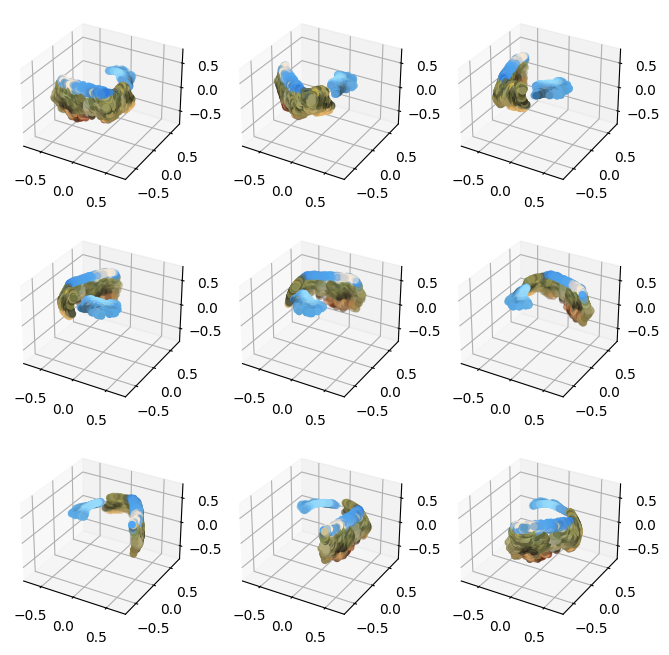

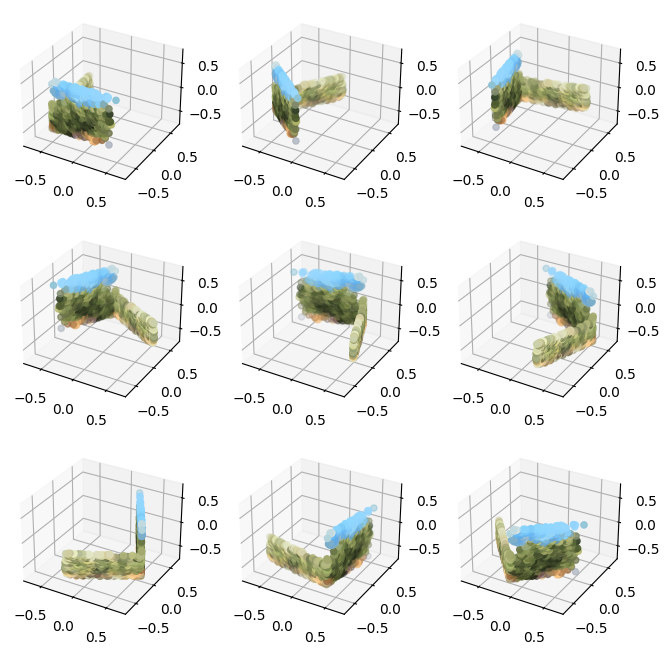

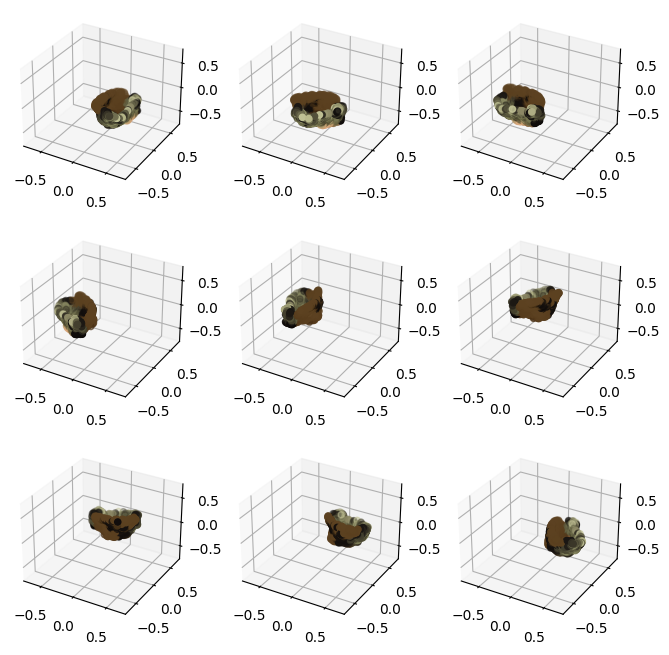

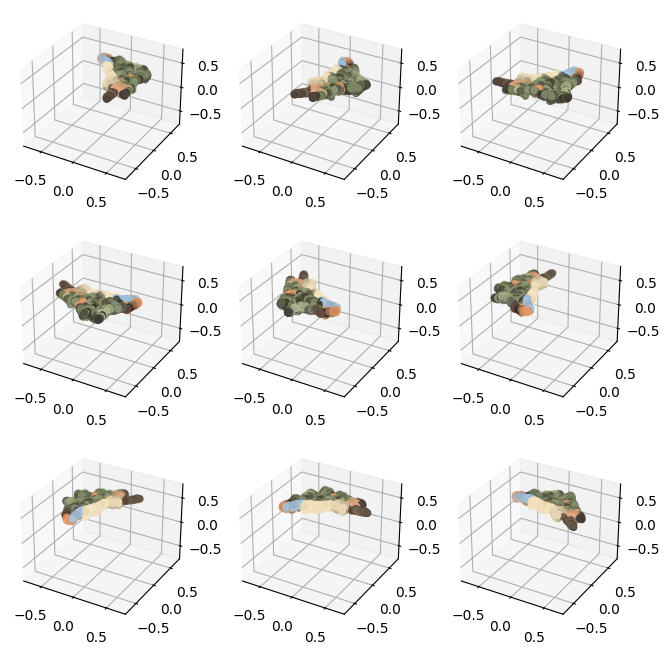

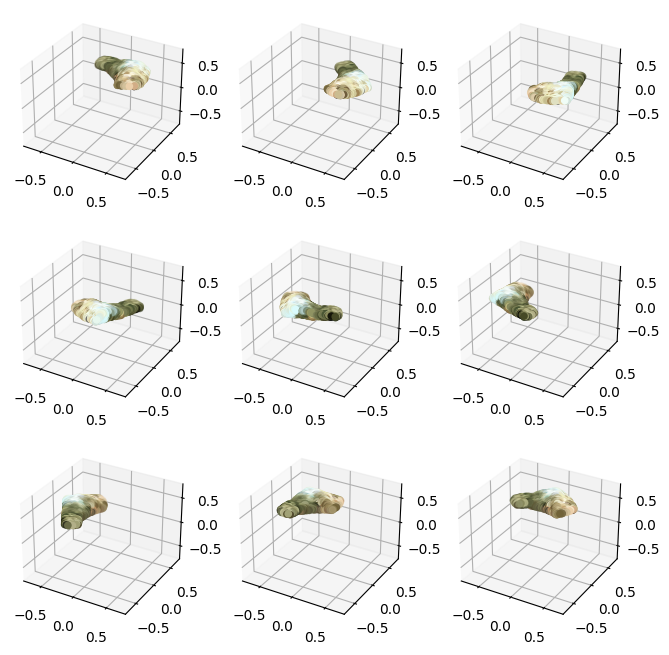

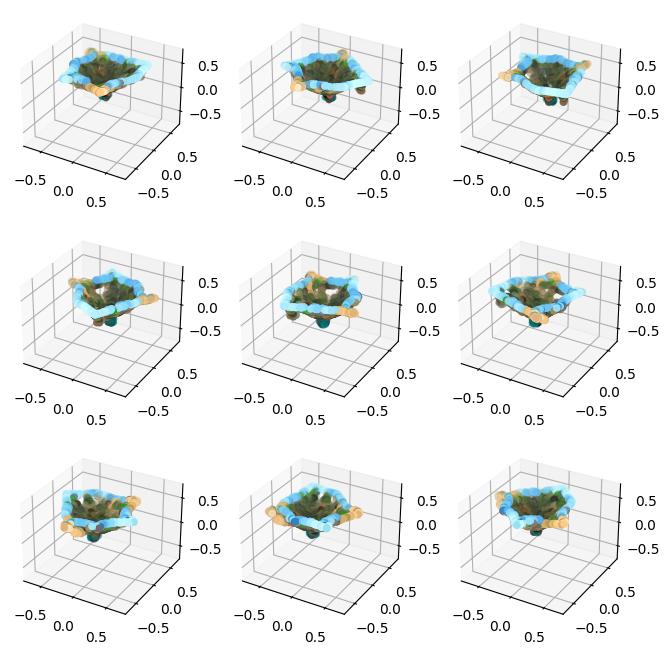

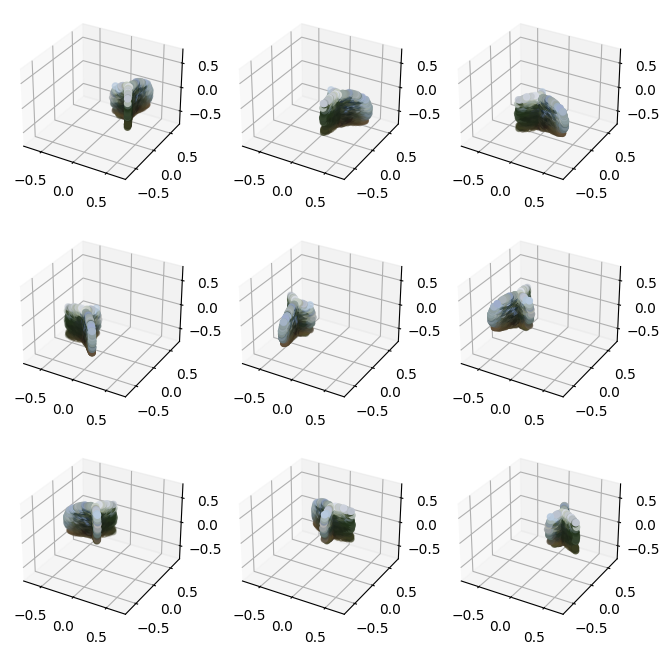

In [ ]:
import pandas as pd
folder_path="/content/drive/MyDrive/olive/segmented"
csv="/content/drive/MyDrive/olive/Tree_height.csv"

import os
# Iterate over each file in the folder

reader = pd.read_csv(csv)
for filename in os.listdir(folder_path):
      # Check if the file is an image
      if filename.endswith('.jpg') or filename.endswith('.png'):
        img=Image.open(os.path.join(folder_path,filename))
        samples=None
        for x in tqdm(sampler.sample_batch_progressive(batch_size=1, model_kwargs=dict(images=[img]))):
          samples = x
        pc = sampler.output_to_point_clouds(samples)[0]
        fig = plot_point_cloud(pc, grid_size=3, fixed_bounds=((-0.75, -0.75, -0.75),(0.75, 0.75, 0.75)))


In [ ]:
print(file["label"])

In [ ]:
file.close()

In [ ]:
import numpy as np

In [13]:
h5_data=np.array(h5_data)
h5_label=np.array(h5_label)

In [14]:
h5_data[0]

array([[-0.2398791 , -0.3758104 ,  0.49633503],
       [ 0.13941556,  0.15172002,  0.4506307 ],
       [ 0.3690092 ,  0.03747756,  0.4111021 ],
       ...,
       [ 0.0577738 , -0.09213308,  0.45105866],
       [ 0.35615194, -0.27599066,  0.41922307],
       [ 0.31110168, -0.29136053,  0.41768798]], dtype=float32)

In [15]:
import h5py


In [ ]:
len(h5_data[399])

1024

In [16]:
len(h5_label)

348

In [17]:
import h5py
import numpy as np

# Create a new HDF5 file
file = h5py.File("/content/drive/MyDrive/olive/ply_data_24_07.h5", "w")

#Create datasets within the file
data_dataset = file.create_dataset("data", shape=(348, 1024,3), dtype='float32')
label_dataset = file.create_dataset("label", shape=(348,1), dtype='float32')


# Write data to the datasets
data_dataset[:] = h5_data
label_dataset[:] = h5_label

# Close the file
file.close()

TypeError: ignored

In [ ]:
len(c['data'])

10

In [ ]:
file = h5py.File("/content/drive/MyDrive/olive/ply_data_12_07.h5", "r+")

In [ ]:
file.keys()

<KeysViewHDF5 ['data', 'label']>

In [ ]:
file.keys()

<KeysViewHDF5 ['data', 'label']>

In [ ]:
file["data"]

<HDF5 dataset "data": shape (400, 1024, 3), type "<f4">

In [ ]:
file["data"][399]

array([[ 0.17445879,  0.1587206 ,  0.03710627],
       [ 0.307178  , -0.05209649, -0.13636507],
       [ 0.31601554, -0.06606841, -0.12283432],
       ...,
       [ 0.3359669 ,  0.15373303, -0.05965009],
       [ 0.36963794, -0.04553983,  0.02781428],
       [ 0.32277566,  0.2248104 ,  0.00488948]], dtype=float32)

In [ ]:
file["label"]

<HDF5 dataset "label": shape (400,), type "<i4">

In [ ]:
file["label"][399]

0

In [ ]:
file["label"][398]

0

In [ ]:
file["label"][1]

2

In [ ]:
file.close()

In [ ]:
file = h5py.File("/content/drive/MyDrive/olive/ply_data_12_07.h5", "r+")

In [ ]:
del file["label"]

In [ ]:
file.keys()

<KeysViewHDF5 ['data']>

In [18]:
import pandas as pd
import numpy as np
folder_path="/content/drive/MyDrive/olive/green_only"
csv="/content/drive/MyDrive/olive/Tree_height.csv"

h5_label=[]
#h5_data=[]
import os
# Iterate over each file in the folder

reader = pd.read_csv(csv)
for filename in os.listdir(folder_path):
      # Check if the file is an image
      if filename.endswith('.jpg') or filename.endswith('.png'):
        for j in range(len(reader)):
          if reader["filename"][j] == filename:
            # Extract the height from the current row
            height = reader["height"][j]
        h5_label.append(np.array([height]))


h5_label=np.array(h5_label)

In [19]:
h5_label

array([[2.96],
       [2.63],
       [3.13],
       [4.63],
       [4.64],
       [1.46],
       [2.  ],
       [2.68],
       [2.24],
       [2.88],
       [1.48],
       [2.66],
       [3.15],
       [3.38],
       [2.95],
       [3.7 ],
       [2.86],
       [0.6 ],
       [2.55],
       [3.33],
       [2.88],
       [2.2 ],
       [2.76],
       [2.92],
       [2.9 ],
       [2.46],
       [3.1 ],
       [3.05],
       [2.96],
       [3.8 ],
       [2.57],
       [2.09],
       [3.49],
       [3.96],
       [3.65],
       [3.95],
       [2.84],
       [3.86],
       [3.82],
       [1.58],
       [2.1 ],
       [2.34],
       [2.84],
       [3.99],
       [2.78],
       [0.8 ],
       [3.02],
       [2.71],
       [2.31],
       [3.07],
       [2.  ],
       [3.58],
       [3.82],
       [4.12],
       [2.09],
       [2.16],
       [3.89],
       [4.56],
       [2.32],
       [1.71],
       [2.37],
       [0.61],
       [3.65],
       [2.41],
       [3.92],
       [1.45],
       [1.

In [20]:
type(h5_label[0])

numpy.ndarray

In [21]:
h5_label[399]

IndexError: ignored

In [22]:
import h5py
import numpy as np

# Create a new HDF5 file
file = h5py.File("/content/drive/MyDrive/olive/ply_data_244_07.h5", "w")

#Create datasets within the file
data_dataset = file.create_dataset("data", shape=(348, 1024,3), dtype='float32')
label_dataset = file.create_dataset("label", shape=(348,1), dtype='float32')


# Write data to the datasets
data_dataset[:] = h5_data
label_dataset[:] = h5_label

# Close the file
file.close()

In [23]:
import h5py

In [24]:
file = h5py.File("/content/drive/MyDrive/olive/ply_data_244_07.h5", "r")

In [25]:
data1=file["data"]

In [26]:
label1=file["label"]

In [27]:
print(len(data1))

348


In [ ]:
print(len(label1))

400


In [ ]:
type(data1)

h5py._hl.dataset.Dataset

In [ ]:
import numpy as np

In [ ]:
data1=np.array(data1)

In [ ]:
label1=np.array(label1)

In [ ]:
data2=np.concatenate((data1, data1), axis=0)
len(data2)

800

In [ ]:
label2=np.concatenate((label1, label1), axis=0)
len(label2)

800

In [ ]:
data3=np.concatenate((data2, data2), axis=0)
len(data3)

1600

In [ ]:
label3=np.concatenate((label2, label2), axis=0)
len(label3)

1600

In [ ]:
data4=np.concatenate((data3, data1), axis=0)
len(data4)

2000

In [ ]:
label4=np.concatenate((label3, label1), axis=0)
len(label4)

2000

In [ ]:
data4=np.concatenate((data4, data1[:48]), axis=0)
len(data4)

2048

In [ ]:
label4=np.concatenate((label4, label1[:48]), axis=0)
len(label4)

2048

In [ ]:
import h5py
import numpy as np

# Create a new HDF5 file
file = h5py.File("/content/drive/MyDrive/olive/ply_data_13_07.h5", "w")

#Create datasets within the file
data_dataset = file.create_dataset("data", shape=(2048, 1024,3), dtype='float32')
label_dataset = file.create_dataset("label", shape=(2048,1), dtype='float32')


# Write data to the datasets
data_dataset[:] = data4
label_dataset[:] = label4

# Close the file
file.close()

In [ ]:
file = h5py.File("/content/drive/MyDrive/olive/ply_data_13_07.h5", "r+")

In [ ]:
file["data"]

<HDF5 dataset "data": shape (400, 1024, 3), type "<f4">

In [ ]:
file["label"]

<HDF5 dataset "label": shape (400, 1), type "<f4">